In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
link = 'https://drive.google.com/file/d/1TGHekDPdbJQjF8iLP5J58T0clqz2rrjL/view?usp=sharing'
path = "https://drive.google.com/uc?export=download&id="+ link.split("/")[-2]
df = pd.read_csv(path)
df.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,has_student_cnt,difficulty,learning_stage,cheating
0,2019-05-01 06:45:00+00:00,dJk8f4bqY/iRA7oVNzBYM8vtOm8XvgPxcoYy+mOwTuY=,tcefpcahExZLA6gms/r4H1DHPHzmBUwg8h7hfNlV4sc=,4pDOyeqUIPE/UY/LZjK2y/MsUUB5/+BsQcTsj8BMzFQ=,3,1,True,8,1,0,False,275719,10,0,easy,elementary,0
1,2019-05-01 07:30:00+00:00,yMtJ95VxxbuqWsxV5OicL3TYo86oC0Rn9iKy8cUm90s=,3cg9wquB/Sf1whKNOekAQ/XUQcTUeXeW01l06R+BbNE=,S0j1Ry8rhnymKIp/9fiiMiQVvu1J8a9VI/yKtwclACo=,8,1,True,8,1,0,False,60837,10,0,easy,elementary,0
2,2019-05-01 07:45:00+00:00,r4xa2pAreiDQeNzIJYkk/8IOzKJGvKqBguTqsIsKauU=,ViIxd7sl/Dp2C0nC24swu3Cm5o8UkaEMgyMuUp7pq0g=,t7MThCasM6oaABNzFzljWWlWNmHSFHauc4tCFAY+eAU=,8,2,True,46,1,0,False,582498,97,0,easy,elementary,0
3,2019-05-01 08:15:00+00:00,ESTiGJ4iybOV7T+zrZw+AgE0g8UNj7ZTbdpnMCd2R2U=,00KEZbwE/6qJ+WSl9TwUEgbwi/wmnEVgeCnGzi4/EYo=,zbLAOaiLjHZDCBc6rPbuDqwsvUSeFxk9ofM4KBwwQes=,5,1,True,33,1,0,False,21300,1,0,normal,elementary,0
4,2019-05-01 08:15:00+00:00,fo0e8Za+Io+VdNu3Hy4GE2Ux1mTh76k2igiZtrThMCo=,00KEZbwE/6qJ+WSl9TwUEgbwi/wmnEVgeCnGzi4/EYo=,ged8VYe3DG5I55+Vkw+lP2LatMfGOor3nA6LILELx4E=,5,1,True,115,1,0,False,13125,1,0,normal,elementary,0


In [ ]:
# One-hot encoding for Difficulty and Learning_stage columns
difficulty_encoded = pd.get_dummies(df['difficulty'], prefix='difficulty')
df = pd.concat([df, difficulty_encoded], axis=1)
df = df.drop('difficulty', axis=1)

df['learning_stage'] = df['learning_stage'].replace({'elementary': 1, 'junior': 2, 'senior': 3})

<ipython-input-27-6d0d2cc5588c>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['learning_stage'] = df['learning_stage'].replace({'elementary': 1, 'junior': 2, 'senior': 3})


In [ ]:
df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW'])

df['hour'] = df['timestamp_TW'].dt.hour
df['minute'] = df['timestamp_TW'].dt.minute
df['weekday'] = df['timestamp_TW'].dt.weekday
df['day'] = df['timestamp_TW'].dt.day
df['month'] = df['timestamp_TW'].dt.month

In [ ]:
df =df.drop(columns = 'timestamp_TW')

In [ ]:
df = df.drop(columns = ['uuid', 'ucid', 'upid'])

In [ ]:
X = df.drop(columns = "cheating")
y = df["cheating"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 43)

print(X_train.shape, X_test.shape)

(10029, 19) (2508, 19)


In [ ]:
!pip install pytorch_tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

cat_idxs = []
cat_dims = []
cat_emb_dim = []

# Trọng số xử lý mất cân bằng
class_weights = {0: 1, 1: 11}


# Khởi tạo mô hình TabNetClassifier với đầy đủ tham số
clf = TabNetClassifier(
    n_d=16, n_a=16,  # Kích thước decision layer & attention
    n_steps=7, gamma=1.5,  # Số bước và độ tái sử dụng feature
    n_independent=2, n_shared=2,  # Kiểm soát số lớp chung & riêng
    cat_idxs=cat_idxs, cat_emb_dim=cat_emb_dim,  # Embedding categorical
    optimizer_fn=torch.optim.Adam,  # Sử dụng Adam Optimizer
    optimizer_params=dict(lr=0.02),  # Learning rate = 0.01
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":10, "gamma":0.9},
    mask_type="sparsemax",  # Sử dụng sparsemax cho feature selection
    lambda_sparse=1e-3,  # Điều chỉnh sparsity để chọn lọc feature
    momentum=0.02,  # BatchNorm momentum
    clip_value=2.0,  # Clipping gradient
    verbose=1,  # Hiển thị log
    device_name='auto'
)
# Convert boolean columns to integers (0 or 1)
for col in X_train.select_dtypes(include=['bool']).columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

X_train_np = X_train.values  # Chuyển thành NumPy array
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Huấn luyện mô hình
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'test'],
    eval_metric=['auc', 'balanced_accuracy'],
    max_epochs=100, patience=60,
    batch_size=512, virtual_batch_size=128,
    num_workers=0,
    weights=class_weights,  # Trọng số cho lớp mất cân bằng
    drop_last=False
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11163 | train_auc: 0.59639 | train_balanced_accuracy: 0.58073 | test_auc: 0.58723 | test_balanced_accuracy: 0.56531 |  0:00:02s
epoch 1  | loss: 0.65424 | train_auc: 0.57239 | train_balanced_accuracy: 0.55763 | test_auc: 0.53783 | test_balanced_accuracy: 0.52465 |  0:00:04s
epoch 2  | loss: 0.58932 | train_auc: 0.53914 | train_balanced_accuracy: 0.53607 | test_auc: 0.54636 | test_balanced_accuracy: 0.52744 |  0:00:07s
epoch 3  | loss: 0.57542 | train_auc: 0.7048  | train_balanced_accuracy: 0.66212 | test_auc: 0.65785 | test_balanced_accuracy: 0.63965 |  0:00:09s
epoch 4  | loss: 0.58027 | train_auc: 0.71929 | train_balanced_accuracy: 0.69633 | test_auc: 0.71257 | test_balanced_accuracy: 0.68022 |  0:00:12s
epoch 5  | loss: 0.5792  | train_auc: 0.75201 | train_balanced_accuracy: 0.6958  | test_auc: 0.70827 | test_balanced_accuracy: 0.67827 |  0:00:14s
epoch 6  | loss: 0.56968 | train_auc: 0.76406 | train_balanced_accuracy: 0.69386 | test_auc: 0.71732 | test_balanced_a

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
from sklearn.metrics import classification_report
probas = clf.predict_proba(X_test_np)[:, 1]
threshold = 0.4
y_pred_thresh = (probas >= threshold).astype(int)

print(classification_report(y_test.values, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2294
           1       0.56      0.73      0.63       214

    accuracy                           0.93      2508
   macro avg       0.76      0.84      0.79      2508
weighted avg       0.94      0.93      0.93      2508



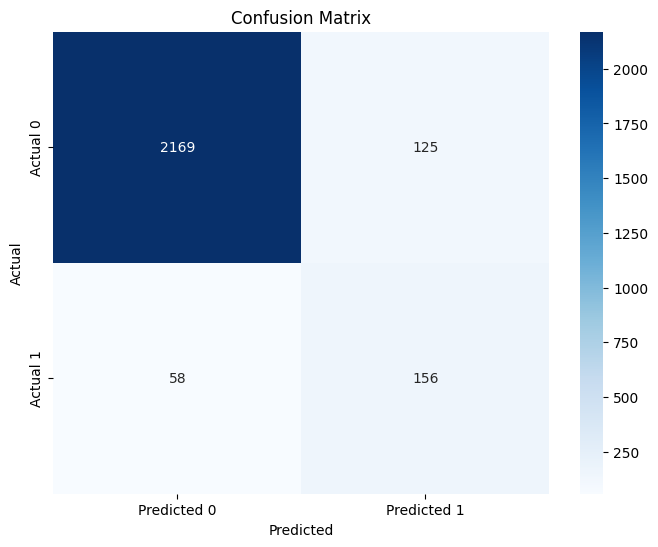

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_thresh)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_results = X_test.copy()
test_results["Predicted_Label"] = y_pred_thresh.astype(int)
test_results["Predicted_Probability_Cheat"] = probas

cheating_cases = test_results[test_results["Predicted_Label"] == 1]
cheating_cases

,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,has_student_cnt,...,difficulty_easy,difficulty_hard,difficulty_normal,hour,minute,weekday,day,month,Predicted_Label,Predicted_Probability_Cheat
1748,8,2,1,5,1,0,0,39379,19,0,...,0,1,0,0,45,6,12,5,1,0.980449
8084,48,3,1,6,1,0,0,42110,6,0,...,0,0,1,21,15,1,4,6,1,0.511423
2590,5,1,1,4,1,0,0,412751,81,0,...,1,0,0,18,30,3,16,5,1,0.470293
2151,5,1,1,3,1,0,0,25518,8,0,...,1,0,0,16,45,1,14,5,1,0.703980
4880,2,1,1,3,1,0,0,433787,69,0,...,1,0,0,21,0,3,30,5,1,0.764808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12186,46,3,1,6,1,0,0,271977,87,0,...,0,0,1,17,0,1,11,6,1,0.480795
10304,15,1,0,6,1,6,1,505611,85,0,...,0,0,1,21,45,5,8,6,1,0.837865
1743,10,1,1,3,1,0,0,1830285,234,0,...,1,0,0,22,45,5,11,5,1,0.760608
6935,25,2,1,2,1,0,0,104409,14,0,...,1,0,0,20,0,0,3,6,1,0.922815
